MSc in Computer Science @AUEB - Natural Language Processing

Assignment 1 - N-gram Language Models and Context-Aware Spelling Corrector, Panagiotis Kaliosis
, Dimitris Mamakas

First of all, let's install NLTK.

In [ ]:
!pip install -q -U nltk
!pip install -q transformers
!pip3 install -q evaluate
!pip3 install -q jiwer

Importing nltk and downloading the Reuters corpus

In [ ]:
import nltk
nltk.download('reuters')
from nltk.corpus import reuters
nltk.download('punkt')
from transformers import BertTokenizer
from pprint import pprint
from nltk import sent_tokenize
from collections import Counter
from nltk.util import ngrams
import math
from tokenizers import BertWordPieceTokenizer
import random
from matplotlib import pyplot as plt
import copy
from copy import deepcopy

[nltk_data] Downloading package reuters to /root/nltk_data...
[nltk_data]   Package reuters is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


The Reuters corpus has already divided the docs in training and test texts. Let's set them apart and store them in two different lists.

In [ ]:
def isTest(fileid):
    return fileid[:4]=='test'


In [ ]:
#Generate the train, dev and test subsets
test_subset = [f for f in reuters.fileids() if isTest(f) == True]
training_subset = [f for f in reuters.fileids() if isTest(f) == False]

num_training_docs = math.trunc(len(training_subset) * 0.85)
num_test_docs = math.trunc(len(test_subset) * 0.8)

dev_subset = []
dev_subset.extend(training_subset[num_training_docs:])
dev_subset.extend(test_subset[num_test_docs:])

training_subset = training_subset[:num_training_docs]
test_subset = test_subset[:num_test_docs]



Exploring the number of training, development and test texts, as well as the percentage of them.

In [ ]:
print("Training subset has: %d texts" % len(training_subset))
print("Dev subset has: %d texts" % len(dev_subset))
print("Test subset has: %d texts" % len(test_subset))

train_percentage = (len(training_subset) / (len(training_subset) + len(dev_subset) + len(test_subset))) * 100
dev_percentage = (len(dev_subset) / (len(training_subset) + len(dev_subset) + len(test_subset))) * 100
test_percentage = (len(test_subset) / (len(training_subset) + len(dev_subset) + len(test_subset))) * 100

print('\nTraining percentage: %.2f %s\nDev percentage: %.2f %s\nTest percentage: %.2f %s' % (train_percentage, '%', dev_percentage, '%', test_percentage, '%'))

Training subset has: 6603 texts
Dev subset has: 1770 texts
Test subset has: 2415 texts

Training percentage: 61.21 %
Dev percentage: 16.41 %
Test percentage: 22.39 %


Let's see how subword tokenization works.
I will now tokenize the texts using the NLTK library and not the pre-tokenized sentences of the Reuters corpus.

In [ ]:
# slice the docs into sentences
def get_raw_sentences(subset, sentences_list):
  for f in subset:
    sentences_list.append(sent_tokenize(reuters.raw(f)))
  return sentences_list

In [ ]:
# define sentences lists for the three subsets 
sentences = []
dev_sentences = []
test_sentences = []

# and call the above function
sentences = get_raw_sentences(training_subset, sentences)
dev_sentences = get_raw_sentences(dev_subset, dev_sentences)
test_sentences = get_raw_sentences(test_subset, test_sentences)

We will use the Tweet Tokenizer in order to tokenize the words from the sentences of every training text, that are contained in the sentences list.

In [ ]:
def tokenize_in_words(sentences_list, tokenizer):
  tokenized = []
  for sent in sentences_list:
    for s in sent:
      tokenized.append(tokenizer.tokenize(s))
  return tokenized

In [ ]:
from nltk import word_tokenize
from nltk.tokenize import TweetTokenizer

#Define the tokenizer
#tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
tokenizer = TweetTokenizer()

#and call the function on every subset
tokenized = tokenize_in_words(sentences, tokenizer)
dev_tokenized = tokenize_in_words(dev_sentences, tokenizer)
test_tokenized = tokenize_in_words(test_sentences, tokenizer)

In [ ]:
def to_lower_case(subset):
  for s in subset:
    for i in range(0,len(s)):
      s[i] = s[i].lower()
  return subset

In [ ]:
tokenized = to_lower_case(tokenized)
dev_tokenized = to_lower_case(dev_tokenized)
test_tokenized = to_lower_case(test_tokenized)

Adding all the words of all the sentences in one list. It will be needed in order to make our lifes easier when calculating the frequency distribution.

In [ ]:
#Retrieve all the words of all the sentences

tokens = [w for s in tokenized for w in s]
dev_tokens = [w for s in dev_tokenized for w in s]
test_tokens = [w for s in test_tokenized for w in s]


print("There are %d words in the training subset" % len(tokens))
print("There are %d words in the dev subset" % len(dev_tokens))
print("There are %d words in the test subset" % len(test_tokens))

There are 964098 words in the training subset
There are 243764 words in the dev subset
There are 346776 words in the test subset


**Create the Vocabulary & Tokens Frequency**

In [ ]:
def get_vocab(words, min):
  freqs = nltk.FreqDist(words)
  vocab = []

  for w in words:
    if freqs[w] > min:
      vocab.append(w)

  return vocab


In [ ]:
#set the min frequency and call the function
min_freq = 5
vocab = get_vocab(tokens, min_freq)
print(len(vocab))

912319


In [ ]:
frequency = Counter(vocab)
for s in vocab:
    if frequency[s] == 0:
      print(s[i] , ' ' ,frequency[s[i]])

In [ ]:
def replace_OOV_with_UNK(vocab, subset, special_char):
    frequency = Counter(vocab)
    
    for sent in subset:
        for i in range(0, len(sent)):
            if frequency[sent[i]] == 0:
                sent[i] = special_char
    
    return subset


In [ ]:
#and call the method on every set
tokenized = replace_OOV_with_UNK(vocab, tokenized, '<UNK>')
dev_tokenized = replace_OOV_with_UNK(vocab, dev_tokenized, '<UNK>')
test_tokenized = replace_OOV_with_UNK(vocab, test_tokenized, '<UNK>')

**Create and count n-grams frequency (NLTK)**

In [ ]:
unigram_counter = Counter()
bigram_counter = Counter()
trigram_counter = Counter()

#train the n-grams on the train data
for s in tokenized:
    unigram_counter.update([gram for gram in ngrams(s, 1, pad_left=True, pad_right=True,
                                                   left_pad_symbol='<s>',right_pad_symbol='<e>') ])
    bigram_counter.update([gram for gram in ngrams(s, 2, pad_left=True, pad_right=True,
                                                   left_pad_symbol='<start>',right_pad_symbol='<end>') ])
    trigram_counter.update([gram for gram in ngrams(s, 3, pad_left=True, pad_right=True,
                                                   left_pad_symbol='<start>',right_pad_symbol='<end>') ])

In [ ]:
print('5 most common unigrams: ')
pprint(unigram_counter.most_common(5))
print('\n5 most common bigrams: ')
pprint(bigram_counter.most_common(5))
print('\n5 most common trigrams: ')
pprint(trigram_counter.most_common(5))

5 most common unigrams: 
[(('<UNK>',), 51779),
 (('the',), 43374),
 (('.',), 40757),
 ((',',), 37832),
 (('of',), 23144)]

5 most common bigrams: 
[(('.', '<end>'), 30900),
 (('<UNK>', ','), 6807),
 (('<start>', 'the'), 5614),
 (('said', '.'), 5010),
 (('of', 'the'), 4223)]

5 most common trigrams: 
[(('.', '<end>', '<end>'), 30900),
 (('<start>', '<start>', 'the'), 5614),
 (('said', '.', '<end>'), 5010),
 (('.', 's', '.'), 3389),
 (('u', '.', 's'), 3384)]


**Calculate bi-gram probability.**



`P(w2|w1) = (c(w1,w2) + a) / (c(w1) +|V|)`

In [ ]:
def bigram_probability(w1, w2, alpha, V):
  prob = (bigram_counter[(w1,w2)] + alpha) / (unigram_counter[w1,] + alpha*V)
  return prob

In [ ]:
#check how the bi-gram probability works on a given bi-gram
probability = bigram_probability('<start>', 'The', 1, len(set(tokens)))
print(probability)

2.617115938236064e-05


**Calculate tri-gram probability.**


`P(w3|w1, w2) = (c(w1,w2,w3) + a) / (c(w1,w2) +|V|)`






In [ ]:
def trigram_probability(w1, w2, w3, alpha, V):
  prob = (trigram_counter[(w1,w2,w3)] + alpha) / (bigram_counter[w1,w2] + alpha*V)
  return prob

In [ ]:
#check how the tri-gram probability works on a given tri-gram
probability = trigram_probability('the', 'company', 'said', 0.1, len(set(tokens)))
print(probability)

0.13059619604974396


**Calculate the bi-gram  LM Cross Entropy and Perplexity.**

`Cross Entropy = -1/N Σ_bigrams log2(P(w2|w1)`

In [ ]:
def bigram_calculate_HC(test_tokenized_list, alpha, test_vocab_size):

  sum_log_probs = 0
  count_bigrams = 0

  for s in test_tokenized_list:
    s = ['<start>'] + s + ['<end>']

    for idx in range(1, len(s)):
      bigram_prob = bigram_probability(s[idx-1], s[idx], alpha, test_vocab_size)
      sum_log_probs += math.log2(bigram_prob)
      count_bigrams += 1

  HC = - (sum_log_probs / count_bigrams)
  return HC

In [ ]:
V = len(set(vocab))
bigram_HCs = []
bigram_perplexities = []
alphas= []

for i in range(40):
  alphas.append(0.025 * (i+1))
  bigram_HCs.append(bigram_calculate_HC(dev_tokenized, alphas[i], V))
  bigram_perplexities.append(math.pow(2, bigram_HCs[i]))

min_HC = min(bigram_HCs)
min_HC_index = bigram_HCs.index(min_HC)

min_perplexity = min(bigram_perplexities)
min_perplexity_index = bigram_perplexities.index(min_perplexity)

bigram_best_alpha = alphas[min_HC_index]


**Calculate the tri-gram LM cross entropy and perplexity.**

In [ ]:
def trigram_calculate_HC(test_tokenized_list, alpha, test_vocab_size):

  sum_log_probs = 0
  count_trigrams = 0

  for s in test_tokenized_list:
    s = ['<start>'] + ['<start>'] + s + ['<end>'] + ['<end']

    for idx in range(2, len(s)-1):
      trigram_prob = trigram_probability(s[idx-2], s[idx-1], s[idx], alpha, test_vocab_size)
      sum_log_probs += math.log2(trigram_prob)
      count_trigrams += 1

  HC = - (sum_log_probs / count_trigrams)
  return HC

In [ ]:
#calculate the vocabulary length
V = len(set(vocab))

trigram_HCs = []
trigram_perplexities = []
alphas = []

#calculate the HC and Perplexity metrics for the trigram model
for i in range(40):
  alphas.append(0.025 * (i+1))
  trigram_HCs.append(trigram_calculate_HC(dev_tokenized, alphas[i], V))
  trigram_perplexities.append(math.pow(2, trigram_HCs[i]))

min_HC = min(trigram_HCs)
min_HC_index = trigram_HCs.index(min_HC)

min_perplexity = min(trigram_perplexities)
min_perplexity_index = trigram_perplexities.index(min_perplexity)

trigram_best_alpha = alphas[min_HC_index]



In [ ]:
def create_plot(model_perplexity, title):

  fig, axs = plt.subplots(1, 1,figsize=(13,10))
  best_alphas = []

  ymin = min(model_perplexity)
  xpos = model_perplexity.index(ymin)
  xmin = alphas[xpos]    
  best_alphas.append(xmin)

  axs.title.set_text('%s for different alpha values' % title)
  axs.scatter(alphas,model_perplexity,s=20)
  axs.scatter(xmin,ymin,s=200,marker='+',c='r')
  axs.set_xlabel("alpha")
  axs.legend(['','Minimum perplexity for a='+str(round(xmin,4))])
  axs.set_ylabel("Perplexity")

  plt.show()

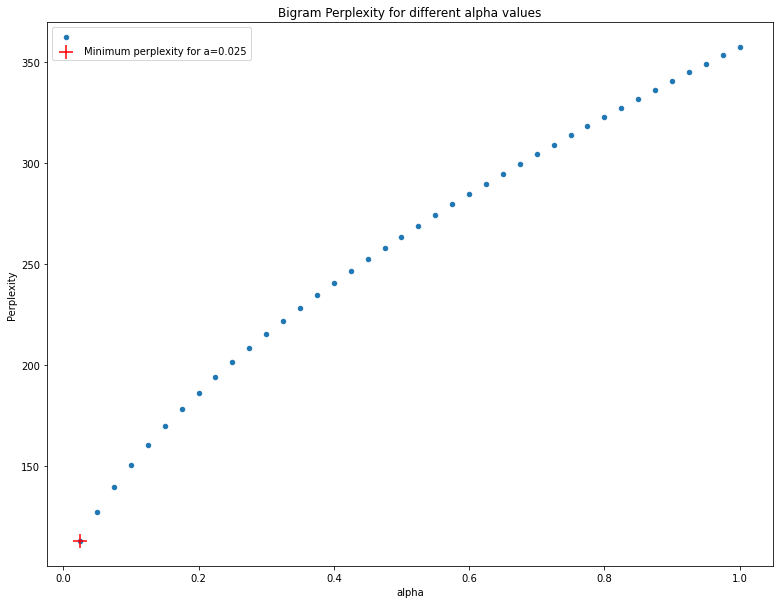

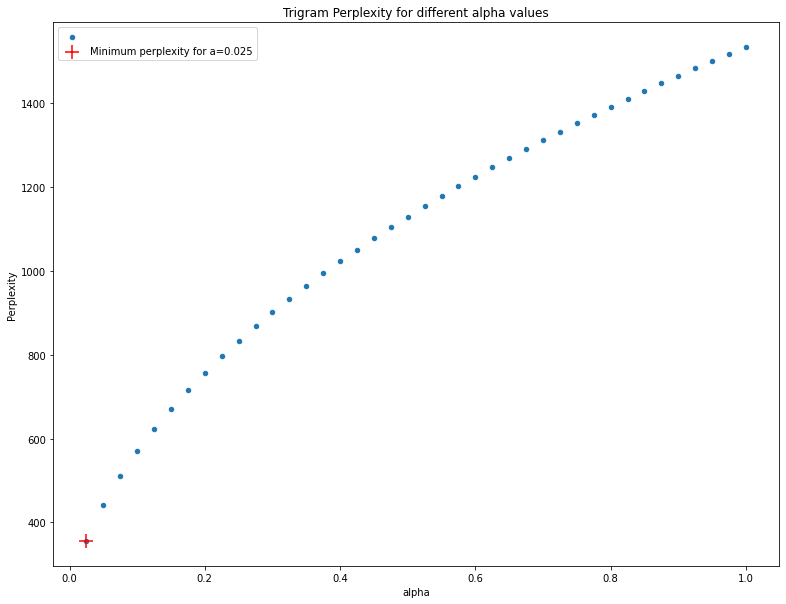

In [ ]:
create_plot(bigram_perplexities, 'Bigram Perplexity')
create_plot(trigram_perplexities, 'Trigram Perplexity')

In [ ]:
# so best alpha = 0.025 for both models
# let's check the best cross-entropy and perplexity value on the test data

best_bigram_cross_entropy = bigram_calculate_HC(dev_tokenized, bigram_best_alpha, V)
best_trigram_cross_entropy = trigram_calculate_HC(dev_tokenized, trigram_best_alpha, V)

best_bigram_perplexity = math.pow(2, best_bigram_cross_entropy)
best_trigram_perplexity = math.pow(2, best_trigram_cross_entropy)

print("Best Bigram Cross Entropy in Dev data: {0:.3f}".format(best_bigram_cross_entropy))
print("Best perplexity in Dev data: {0:.3f}".format(best_bigram_perplexity))
print("Bigram best Alpha = {0:.3f}".format(bigram_best_alpha))

print("\nBest Trigram Cross Entropy in Dev data: {0:.3f}".format(best_trigram_cross_entropy))
print("Best perplexity in Dev data: {0:.3f}".format(best_trigram_perplexity))
print("Trigram best Alpha = {0:.3f}".format(trigram_best_alpha))

Best Bigram Cross Entropy in Dev data: 6.818
Best perplexity in Dev data: 112.791
Bigram best Alpha = 0.025

Best Trigram Cross Entropy in Dev data: 8.472
Best perplexity in Dev data: 355.144
Trigram best Alpha = 0.025


**Beam Seach Decoder**

We search for a path from start to a state of column k that minimizes `Lk = -λ1*logP(t1k) -λ2*log(Pw1k|t1k)`

In [ ]:
from nltk.metrics.distance import edit_distance_align

In [ ]:
# function used in order to present the beam search decoder's result in a nicer way
def present_answer(response):
  response.pop(0)
  estimated_str = ''
  for item in response:
    estimated_str += item + ' '
  return estimated_str

In [ ]:
import itertools
from nltk.tokenize import WhitespaceTokenizer

tokenizer2 = WhitespaceTokenizer()

def beam_search_decoder(word_seq, vocab, alpha, V, BEAM_WIDTH, lamda1, lamda2):
  # word_seq = observed sequence
  # vocab = the LM's vocabulary
  # alpha = the parameter for the add-a smoothing
  # V = vocabulary size
  # BEAM_WIDTH = beam search decoder's search width
  # lamda1, lamda2 = hyperparameters used to weight the significance of P(t) and P(w_i | t_i) 
  # we search for a path from <start> to a state of column k = len(observed_sequence) that minimizes the L_k = - λ1 * log(P(t_1k)) - λ2 * P(w_1k | t_1k)

  word_seq = '<start>' + word_seq # add the special token in the start of the observed sequence
  word_seq = tokenizer.tokenize(word_seq) # tokenize the observed sequence

  prob_observed, edit_distance = 1, 1 

  #if len(word_seq) > BEAM_WIDTH:
    #BEAM_WIDTH = len(word_seq) + 1


  cand_seqs = [['<start>']] * BEAM_WIDTH # cand_seqs stores the most probable sequences in each beam step
  dictionary = {}
  cand_seqs2 = cand_seqs

  for i in range(1, len(word_seq)): # parsing through the observed sequence
    for j in range(0, len(cand_seqs)): # for each canditate sequence...
      for k in range(V): # ...we check every vocabulary word

        prob_observed = 1 # P(t_ik)
        edit_distance = 1 # P(w_i | t_i)
        log_sum = 0 #Lk

        if i == 1: # we only take into account the bigrams (<start>, vocab[k])
          prob_observed = bigram_probability(cand_seqs2[j][i-1], vocab[k], alpha, V)
          edit_distance = 1 / ((nltk.edit_distance(word_seq[i], vocab[k]) + 0.01) / max(len(word_seq[i]), len(vocab[k]))) # inverse levenshtein distance, adding 0.01 in order to avoid division by zero in case the two words are the same word

        if i != 1:

          for l in range(1, i): # we now take into account all the previous bigrams of the candidate sequence and of course all the potential newly added bigrams

            if l != i-1: # calculating probability of previous bigrams of the candidate sequence
              prob_observed *= bigram_probability(cand_seqs2[j][l-1], cand_seqs2[j][l], alpha, V)
              edit_distance *= 1 / ((nltk.edit_distance(word_seq[l], cand_seqs2[j][l]) + 0.01) / max(len(word_seq[l]), len(cand_seqs2[j][l])))

            else: # calculating probability of all the new potential bigrams
              prob_observed *= bigram_probability(cand_seqs2[j][l], vocab[k], alpha, V)
              edit_distance *=  1 / ((nltk.edit_distance(word_seq[i], vocab[k]) + 0.01) / max(len(word_seq[i]), len(vocab[k])))

        log_sum += - lamda1 * math.log2(prob_observed) - lamda2 * math.log2(edit_distance) # calculating Lk
        dictionary[str(cand_seqs[j]) + ' ' + vocab[k]] = log_sum # storing all the new possible sequences in the dictionary

    dictionary = dict(sorted(dictionary.items(), key=lambda item: item[1])) # sorting the dictionary on  dict.values() aka the probability of each sequence
    cand_seqs = list(dictionary.keys())[:BEAM_WIDTH] # storing in candidate sequences the BEAM_WIDTH more probable candidate sequences

    for i in range(len(cand_seqs)):
      cand_seqs2[i] = cand_seqs[i].split(" ") #data structure handling, tokenizing the candidate sequences in order to function properly

    print('CANDIDATE SEQUENCES: ', cand_seqs2)

    if i != (len(word_seq)-1):
      dictionary = {} # clearing the dictionary after each iteration on the observed word sequence
      
  return cand_seqs2[0] # returning the most probable candidate sequence after all the iterations are over


In [ ]:
# function that retrieves all the distinct characters from the given input 
def get_distinct_chars(test_sents):

  unique_characters = []

  letters = []
  symbols = []

  for sentence in test_sents:
    for word in sentence:
      for character in word:
        if character not in unique_characters:
            unique_characters.append(character)

  unique_characters.sort()

  for c in unique_characters:
    if c.isalpha() == True:
      letters.append(c.lower())
    else:
      symbols.append(c)

  return letters, symbols

In [ ]:
test_letters_unique, test_symbols_unique = get_distinct_chars(test_tokenized)
print(test_letters_unique)
print(test_symbols_unique)

['k', 'n', 'u', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
['"', '&', "'", '(', ')', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '<', '>', '?', '^']


In [ ]:
def roll_a_dice(prob):

  rand = random.random()

  if rand <= prob:
    return True
  else:
    return False


In [ ]:
# first of all, let's try to replace each non-space character with another random one
def replace_with_similar(test_sents, letters, symbols, prob):
  
  for i in range(len(test_sents)):
    for j in range(len(test_sents[i])):
      for k in range(len(test_sents[i][j])):

        if roll_a_dice(prob) ==  True:

          if test_sents[i][j].isalpha() ==  True:
            test_sents[i][j] = test_sents[i][j].replace(test_sents[i][j][k], random.choice(letters))
            
          else:
            test_sents[i][j] = test_sents[i][j].replace(test_sents[i][j][k], random.choice(symbols))

  return test_sents

**Evaluation  in terms of Word Error Rate (WER) and Character Error Rate (CER)**

In [ ]:
from evaluate import load
wer = load("wer")
cer = load("cer")

In [ ]:
def find_small_sentences(sent_list, wrong_sent_list):

  small_sents = []
  wrong_sents = []
  c = 0

  for i in range(len(sent_list)):

    if len(sent_list[i]) <= 9 & len(sent_list[i]) > 5:
      small_sents.append(sent_list[i])
      wrong_sents.append(wrong_sent_list[i])
      c += 1

    if c == 5:
      break

  return small_sents, wrong_sents

In [ ]:
test_tokenized_errors = copy.deepcopy(test_tokenized)
test_tokenized_errors = replace_with_similar(test_tokenized_errors, test_letters_unique, test_symbols_unique, 0.08)
references, to_predict = find_small_sentences(test_tokenized, test_tokenized_errors)

In [ ]:
#wrongs = replace_with_similar(small_sents, test_letters_unique, test_symbols_unique, 0.08)

In [ ]:
print(references)

[['annual', 'ore', 'capacity', 'will', 'be', 'about', '750,000', 'tonnes', '.'], ['the', 'analysts', 'agreed', 'the', 'bank', 'was', 'aggressive', '.'], ["that's", 'the', 'kind', 'of', 'deregulation', 'we', 'want', '.', '"'], ['"', 'we', "don't", 'want', 'to', 'make', '<UNK>', '.'], ['suppliers', 'and', 'remove', 'quotas', 'on', 'u', '.', 's', '.']]


In [ ]:
print(to_predict)

[['annual', 'ore', 'capacitc', 'will', 'be', 'aboug', '75(,(((', 'tonnes', '.'], ['ahe', 'analysts', 'agreed', 'txe', 'bank', 'was', 'aggressive', '.'], ["that's", 'the', 'kind', 'of', 'deregulatuon', 'we', 'want', '.', '"'], ['"', 'we', "don't", 'want', 'to', 'mabe', '<UNK>', '.'], ['suuuliers', 'and', 'rnmovn', 'quotas', 'on', 'u', '.', 's', '.']]


In [ ]:
# generate the predictions using the beam search decoder
predictions = []
for i in range(len(references)):
  predictions.append(beam_search_decoder(' '.join(to_predict[i]), vocab, bigram_best_alpha, V, 5, 0.1, 0.9))
for pred in predictions:
  pred.pop(0)

CANDIDATE SEQUENCES:  [["['<start>']", 'annual'], ["['<start>']", 'general'], ["['<start>']", 'final'], ["['<start>']", 'the'], ["['<start>']", 'in']]
CANDIDATE SEQUENCES:  [["['<start>']", 'final', 'ore'], ["['<start>']", 'annual', 'ore'], ["['<start>']", 'general', 'ore'], ["['<start>']", 'in', 'ore'], ["['<start>']", 'the', 'ore']]
CANDIDATE SEQUENCES:  [["['<start>']", 'annual', 'ore', 'imports'], ["['<start>']", 'annual', 'ore', 'deposits'], ["['<start>']", 'annual', 'ore', 'japan'], ["['<start>']", 'annual', 'ore', 'and'], ["['<start>']", 'annual', 'ore', 'exports']]
CANDIDATE SEQUENCES:  [["['<start>']", 'annual', 'ore', 'japan', 'will'], ["['<start>']", 'annual', 'ore', 'exports', 'will'], ["['<start>']", 'annual', 'ore', 'imports', 'will'], ["['<start>']", 'annual', 'ore', 'and', 'will'], ["['<start>']", 'annual', 'ore', 'deposits', 'will']]
CANDIDATE SEQUENCES:  [["['<start>']", 'annual', 'ore', 'imports', 'will', 'be'], ["['<start>']", 'annual', 'ore', 'japan', 'will', 'be']

In [ ]:
def list_sentence_to_string(sentence):
    string_sentence = ''
    for word in sentence:
        string_sentence+=word + ' '
    return string_sentence

In [ ]:
#transform lists to string in order to pass it as an input to the WER, CER functions
for i in range(len(references)):
  print(predictions[i], to_predict[i], references[i])
  predictions[i] = list_sentence_to_string(predictions[i])
  to_predict[i] = list_sentence_to_string(to_predict[i])
  references[i] = list_sentence_to_string(references[i])

['annual', 'ore', 'japan', 'will', 'be', 'about', '75', '(', ',', '(', '(', '(', 'tonnes', '.'] ['annual', 'ore', 'capacitc', 'will', 'be', 'aboug', '75(,(((', 'tonnes', '.'] ['annual', 'ore', 'capacity', 'will', 'be', 'about', '750,000', 'tonnes', '.']
['the', 'analysts', 'agreed', 'the', 'bank', 'was', 'attractive', '.'] ['ahe', 'analysts', 'agreed', 'txe', 'bank', 'was', 'aggressive', '.'] ['the', 'analysts', 'agreed', 'the', 'bank', 'was', 'aggressive', '.']
['that', 'the', 'king', 'of', 'regulation', 'we', 'want', '.', '"'] ["that's", 'the', 'kind', 'of', 'deregulatuon', 'we', 'want', '.', '"'] ["that's", 'the', 'kind', 'of', 'deregulation', 'we', 'want', '.', '"']
['"', 'we', "don't", 'want', 'to', 'make', 'a', '.'] ['"', 'we', "don't", 'want', 'to', 'mabe', '<UNK>', '.'] ['"', 'we', "don't", 'want', 'to', 'make', '<UNK>', '.']
['suppliers', 'and', 'union', 'quotas', 'on', 'u', '.', 's', '.'] ['suuuliers', 'and', 'rnmovn', 'quotas', 'on', 'u', '.', 's', '.'] ['suppliers', 'and', 

In [ ]:
print('REFERENCES: ' , references)
print('WRONGS: ' , to_predict)
print('PREDICTIONS: ' , predictions)

REFERENCES:  ['annual ore capacity will be about 750,000 tonnes . ', 'the analysts agreed the bank was aggressive . ', 'that\'s the kind of deregulation we want . " ', '" we don\'t want to make <UNK> . ', 'suppliers and remove quotas on u . s . ']
WRONGS:  ['annual ore capacitc will be aboug 75(,((( tonnes . ', 'ahe analysts agreed txe bank was aggressive . ', 'that\'s the kind of deregulatuon we want . " ', '" we don\'t want to mabe <UNK> . ', 'suuuliers and rnmovn quotas on u . s . ']
PREDICTIONS:  ['annual ore japan will be about 75 ( , ( ( ( tonnes . ', 'the analysts agreed the bank was attractive . ', 'that the king of regulation we want . " ', '" we don\'t want to make a . ', 'suppliers and union quotas on u . s . ']


In [ ]:
# compute the evaluation scores
wer_score = wer.compute(predictions=predictions, references=references)
cer_score = cer.compute(predictions=predictions, references=references)

In [ ]:
# And print them
print("The WER score is: " + "{:.2f}".format(wer_score))
print("The CER score is: " + "{:.2f}".format(cer_score))

The WER score is: 0.30
The CER score is: 0.16
